## NEMO ocean data loading and plotting with xarray and nereus

In [77]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pylab as plt
import cartopy.feature as cfeature
import numpy as np
import matplotlib.cm as cm

In [26]:
data = xr.open_mfdataset('/gws/nopw/j04/eerie/public/model/data/HadGEM3-GC31-HM/nemo_az094o_1s_*_grid-T_tos.nc.trimmed.nc', 
                         concat_dim='time_counter', combine='nested')

In [27]:
data = data.rename({'time_counter': 'time'})
data = data.rename({'nav_lon': 'longitude'})
data = data.rename({'nav_lat': 'latitude'})

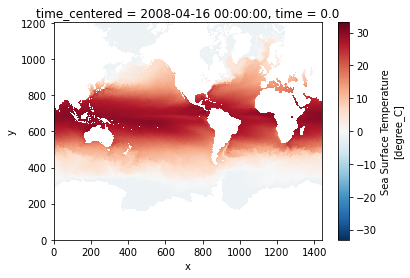

In [28]:
data.tos[0,:].plot()

In [30]:
data

<xarray.Dataset>
Dimensions:               (time: 3, y: 1205, x: 1440, nvertex: 4,
                           axis_nbounds: 2)
Coordinates:
    latitude              (y, x) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude             (y, x) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    time_centered         (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) float64 0.0 0.0 0.0
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lat            (time, y, x, nvertex) float32 dask.array<chunksize=(1, 1205, 1440, 4), meta=np.ndarray>
    bounds_lon            (time, y, x, nvertex) float32 dask.array<chunksize=(1, 1205, 1440, 4), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    tos                   (time, y, x) float32 dask.array<chunksize=(1, 1205, 1440), meta=np.ndarray>
Attributes: (12/14)
    name:         az094o_1m_20080101_20080430
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2019-Jan-25 15:52:48 UTC
    ...           ...
    jbegin:       0
    nj:           101
    TimeStamp:    26/01/2019 12:17:04 +0000
    file_name:    nemo_az094o_1s_20080301-20080601_grid-T.nc.tmp
    history:      Wed Sep 20 17:28:02 2023: ncks -d x,1,1440 -d y,1,1205 /scr...
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...

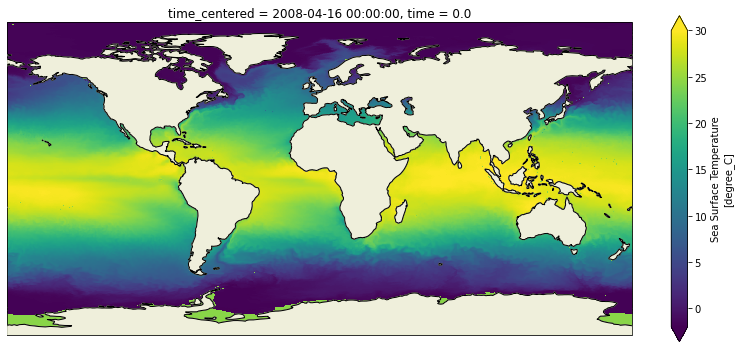

In [45]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
data.tos[0,:].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=True, vmin=-2, vmax=30,
)
# ax.set_extent((-100, 100, 0, 80))
ax.coastlines()
## there is a bug in cartopy https://github.com/SciTools/cartopy/issues/1421 that makes it look terribe without land overlay :)
ax.add_feature(cfeature.LAND, zorder=50)
ax.add_feature(cfeature.COASTLINE, zorder=51)

## Let's try to do it with nereus

In [47]:
import sys
sys.path.append("../../")
import nereus as nr

In [48]:
bbox = [-100, 0, 20, 60]

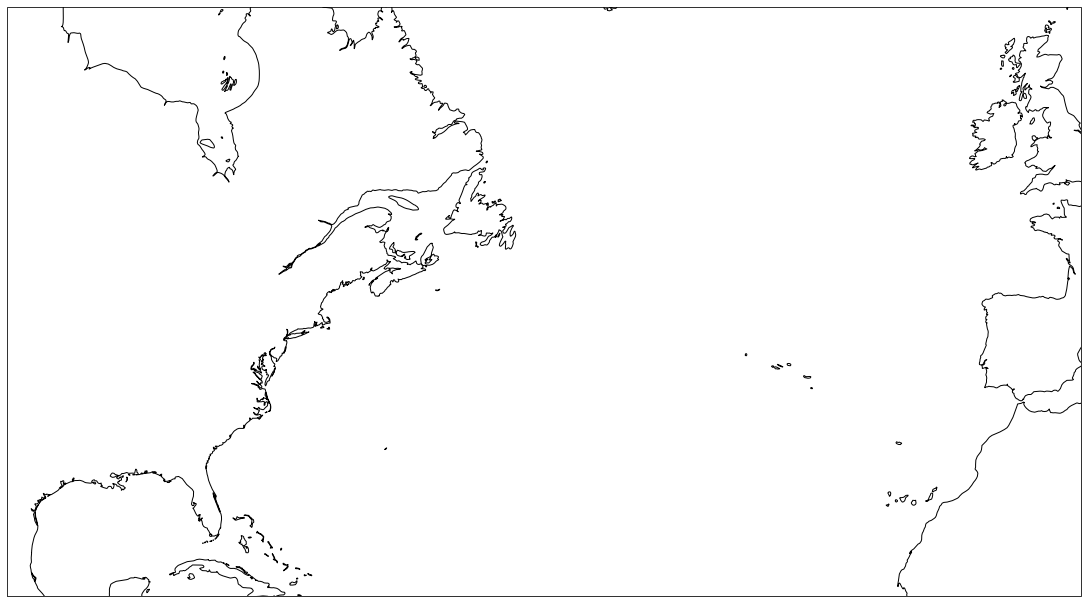

In [50]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines("50m")

In [51]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_Mercator", n_points=100)

In [57]:
distances, inds = nr.create_indexes_and_distances(data.longitude.values.ravel(), data.latitude.values.ravel(), lon2, lat2, k=1, workers=10)

In [74]:
data_sample = data.tos[0,:].values.ravel()
# data_sample2 = data['2t'][1106,:]

radius_of_influence=19000
data_interpolated = data_sample[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

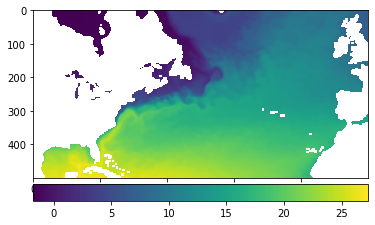

In [75]:
plt.imshow(np.flipud(data_interpolated))
plt.colorbar(orientation='horizontal', pad=0.03)

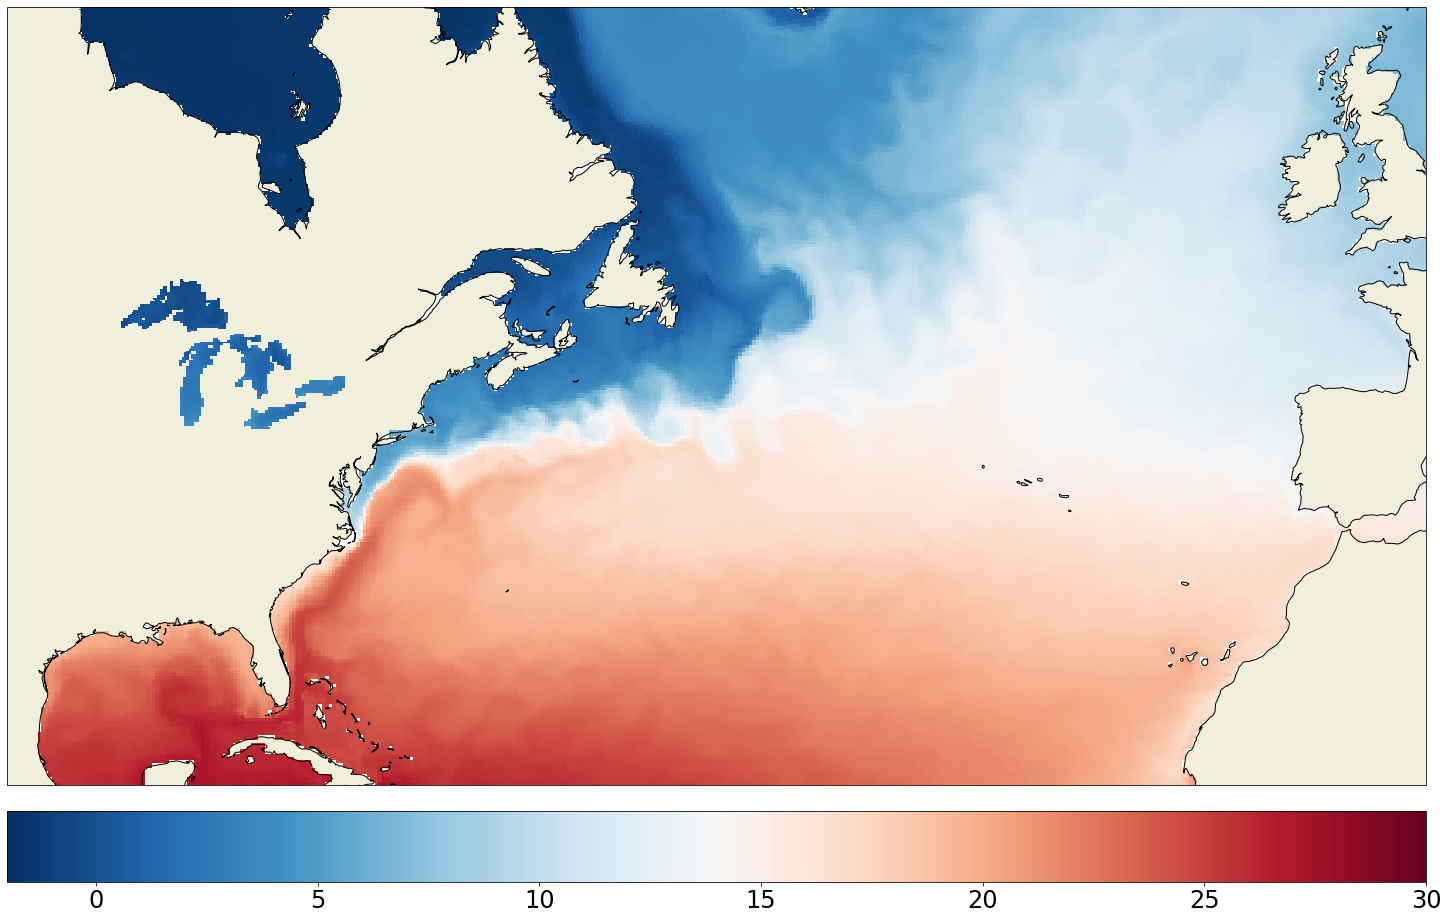

In [79]:
projection_ccrs = ccrs.Mercator()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.Mercator()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(data_interpolated), cmap=cm.RdBu_r,
                vmin=-2, vmax=30,
                extent=(x.min(), x.max(), y.min(), y.max()),
                interpolation='nearest', 
               transform=ccrs.Mercator())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)

## North Polar stereo projection

In [80]:
bbox = [-180, 180, 60, 90]

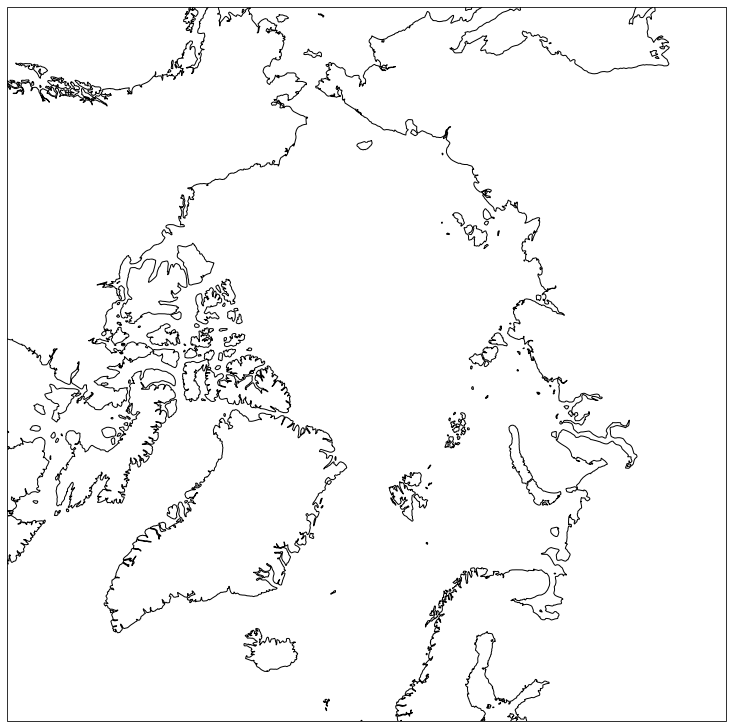

In [81]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines()

In [82]:
from pyproj import CRS
custom_north_polar_stereo = CRS.from_string("+proj=stere +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [83]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [500, 500], projection=custom_north_polar_stereo, n_points=100)

In [84]:
distances, inds = nr.create_indexes_and_distances(data.longitude.values.ravel(), data.latitude.values.ravel(), lon2, lat2, k=1, workers=10)

In [ ]:
data_sample = data['m_ice'][1106,:]

radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

In [85]:
data_sample = data.tos[0,:].values.ravel()
# data_sample2 = data['2t'][1106,:]

radius_of_influence=19000
data_interpolated = data_sample[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

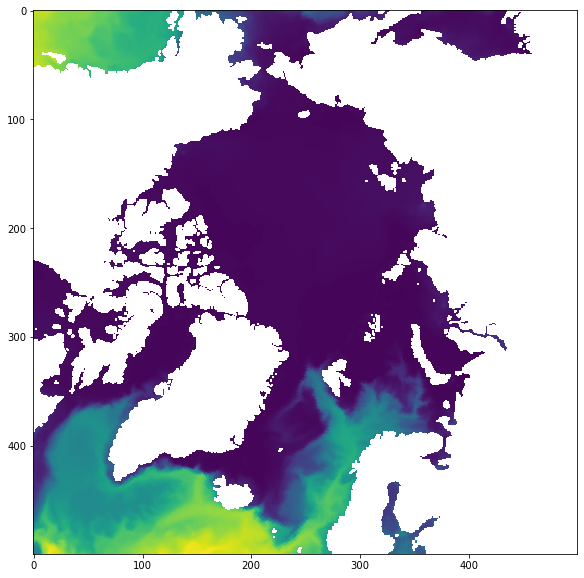

In [88]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(data_interpolated))

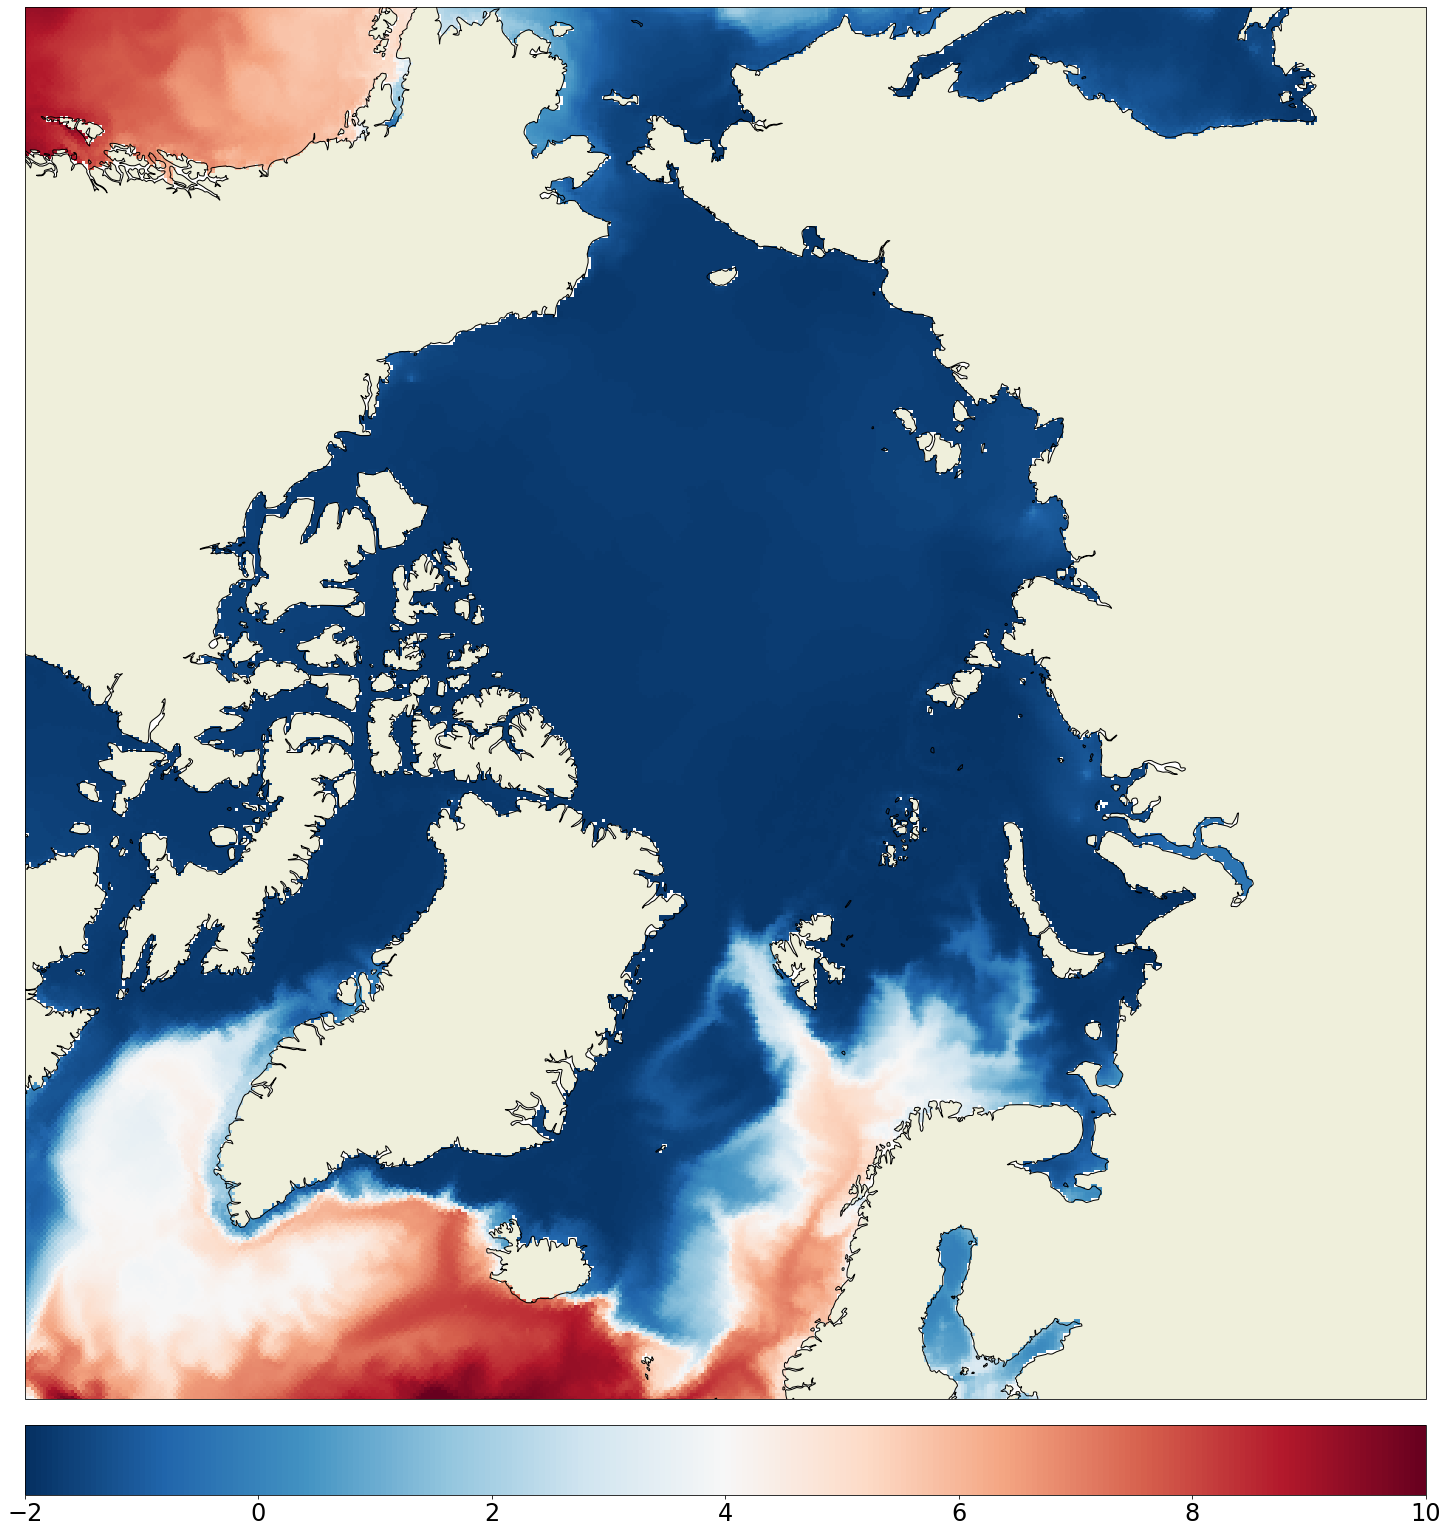

In [90]:
projection_ccrs = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(data_interpolated), cmap=cm.RdBu_r,
                vmin=-2, vmax=10,
                extent=(x.min(), x.max(), y.min(), y.max()),
                interpolation='nearest', 
               transform=ccrs.NorthPolarStereo())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)